In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Q1
## Input data

In [69]:
def plotPoints(points):
    _, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.scatter(points[:,0],points[:,1])
    plt.show()

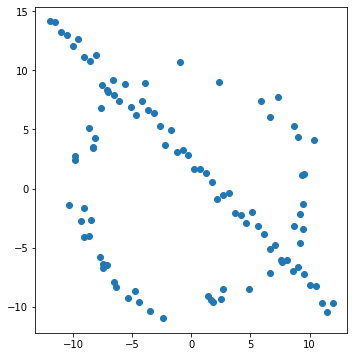

In [70]:
N = 100
half_n = N//2
r = 10
s = r/16
np.random.seed(0)
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

plotPoints(X)

## RANSAC

In [109]:
def findCircle(points, log=False) :
      # Finds the radius and the center of a circle when three points are given
      # 
      # Returns:
      # 1. r: radius
      # 2. h: x-cordinate of the center
      # 3. k: y-cordinate of the center
      # 
      
      assert points.shape == (3,2)
      x1, y1 = points[0][0], points[0][1]
      x2, y2 = points[1][0], points[1][1]
      x3, y3 = points[2][0], points[2][1]

      xc1, yc1 = (x1+x2)/2, (y1+y2)/2
      mc1 = 0
      if y2 == y1:
            mc1 = float('inf')
      else:
            mc1 = (x1-x2)/(y2-y1)
      xc2, yc2 = (x3+x2)/2, (y3+y2)/2
      mc2 = 0
      if y3 == y2:
            mc2 = float('inf')
      else:
            mc2 = (x2-x3)/(y3-y2)

      h = (xc1*mc1-xc2*mc2+yc2-yc1)/(mc1-mc2)
      k = (yc1*mc2-yc2*mc1+(xc2-xc1)*mc1*mc2)/(mc2-mc1)
      r = np.sqrt((h-x1)**2+(k-y1)**2)
      

      return r, h, k

In [122]:
def findInliers(points, r, h, k, threshold=2.0):
    distances = np.sqrt((points[:,0]-h)**2+(points[:,1]-k)**2)
    inlier_indices = np.array(np.abs(distances-r)<threshold)
    inliers = points[inlier_indices]

    return inliers


In [151]:
def plotCircle(ax, r,h,k, color=None, label=None):
    t = np.linspace(0, 2*np.pi, 50)
    x, y = r*np.cos(t)+h, r*np.sin(t)+k
    ax.plot(x, y, color=color, label=label)

In [148]:
def findAndPlotCircle(all_points, selected_points):

    r, h, k = findCircle(selected_points)
    inliers = findInliers(all_points, r, h, k)
    inlier_count = inliers.size
    print("Inlier count: ", inlier_count)

    _, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.scatter(all_points[:,0],all_points[:,1])
    ax.scatter(inliers[:,0],inliers[:,1])
    ax.scatter(selected_points[:,0],selected_points[:,1], color="red")
    
    plotCircle(ax, r,h,k)
    
    plt.axis('off')

    plt.show()
    

Inlier count:  128


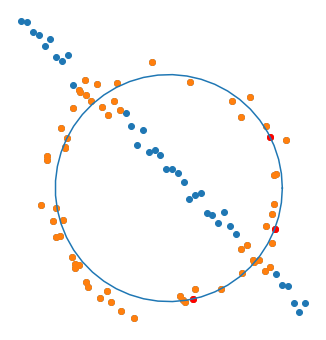

In [149]:
sample_indices = np.random.randint(0, X.shape[0], 3)
samples = X[sample_indices]
findAndPlotCircle(X, samples)

Outlier ratio is 0.5 (slightly less because the line overlaps with the circle). So let us consider it as 0.45

C:\Users\Avishka\AppData\Local\Temp\ipykernel_21136\3728866632.py:28: RuntimeWarning: invalid value encountered in double_scalars
  h = (xc1*mc1-xc2*mc2+yc2-yc1)/(mc1-mc2)
C:\Users\Avishka\AppData\Local\Temp\ipykernel_21136\3728866632.py:29: RuntimeWarning: invalid value encountered in double_scalars
  k = (yc1*mc2-yc2*mc1+(xc2-xc1)*mc1*mc2)/(mc2-mc1)


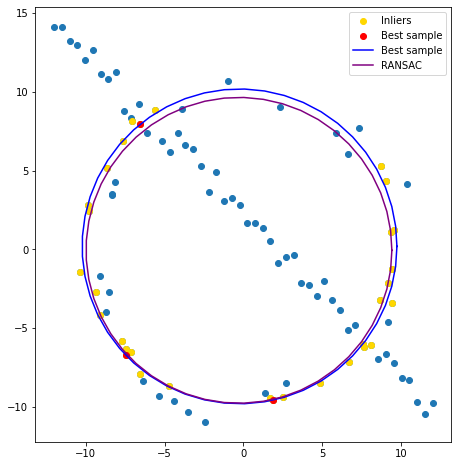

In [168]:
e = 0.45
p = 0.99
s = 3
d = 60
t = 0.48

N = np.log(1-p)/np.log(1-(1-e)**s)*10
potential_circles = []
best_fit_index = 0
max_inlier_count = 0

for _ in range(int(N)):
    sample_indices = np.random.randint(0, X.shape[0], 3)
    samples = X[sample_indices]
    r, h, k = findCircle(samples)
    inliers = findInliers(X, r, h, k, t)
    inlier_count = inliers.size
    if inlier_count > d:
        potential_circles.append({"circle": (r,h,k), "inlier_count": inlier_count, "samples": samples, "inliers": inliers})
        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            best_fit_index = potential_circles.__len__()-1

_, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
ax.scatter(X[:,0], X[:,1])

for i, found_circle in enumerate(potential_circles):
    if i == best_fit_index:
        inliers = found_circle["inliers"]
        ax.scatter(inliers[:,0], inliers[:,1], color="gold", label="Inliers")
        samples = found_circle["samples"]
        ax.scatter(samples[:,0], samples[:,1], color="red", label="Best sample")
        r,h,k = found_circle["circle"]
        plotCircle(ax, r,h,k, "blue", "Best sample")
    else:
        r,h,k = found_circle["circle"]
        plotCircle(ax, r,h,k, "purple", "RANSAC")


plt.legend()
plt.show()


## Other methods

In [55]:
def fitCircleThreshold(points, radius_threshold=2, center_stride=1, radius_step=1):
    assert center_stride >= 1

    x_vals = points[:,0]
    y_vals = points[:,1]
    x_min = x_vals.min()
    x_max = x_vals.max()
    y_min = y_vals.min()
    y_max = y_vals.max()
    print(x_min, x_max, y_min, y_max)

    # iterate over all points
    center_x, center_y, radius = 0, 0, 0
    max_inlier_count = 0
    for i in np.arange(x_min, x_max+center_stride, center_stride):
        for j in np.arange(y_min, y_max+center_stride, center_stride):
            distances = np.sqrt((points[:,0]-1)**2 + (points[:,1]-1)**2)
            radius_max = distances.max()
            for r in np.arange(0, radius_max+radius_step, radius_step):
                inliers = np.array(np.abs(distances-r)<radius_threshold)
                inlier_count = np.count_nonzero(inliers)
                # print(i, j, r, inlier_count)
                if inlier_count > max_inlier_count:
                    # print("updated")
                    max_inlier_count = inlier_count
                    center_x, center_y, radius = i, j, r

    return center_x, center_y, radius

In [65]:
def fitCircleError(points, center_stride=1, radius_step=1):
    assert center_stride >= 1

    x_vals = points[:,0]
    y_vals = points[:,1]
    x_min = x_vals.min()
    x_max = x_vals.max()
    y_min = y_vals.min()
    y_max = y_vals.max()
    print(x_min, x_max, y_min, y_max)

    # iterate over all points
    center_x, center_y, radius = 0, 0, 0
    min_error = float('inf')
    for i in np.arange(x_min, x_max+center_stride, center_stride):
        for j in np.arange(y_min, y_max+center_stride, center_stride):
            distances = np.sqrt((points[:,0]-1)**2 + (points[:,1]-1)**2)
            radius_max = distances.max()
            for r in np.arange(0, radius_max+radius_step, radius_step):
                error = np.sum(np.abs(distances-r))
                # print(i, j, r, inlier_count)
                if error < min_error:
                    # print("updated")
                    min_error = error
                    center_x, center_y, radius = i, j, r

    return center_x, center_y, radius

In [66]:
center_x, center_y, radius = fitCircleError(X)
print(center_x, center_y, radius)
center_x, center_y, radius = fitCircleThreshold(X)
print(center_x, center_y, radius)


-12.0 12.0 -10.951943348417196 14.130171861298038
-12.0 -10.951943348417196 10.0
-12.0 12.0 -10.951943348417196 14.130171861298038
-12.0 -10.951943348417196 10.0


# Q2

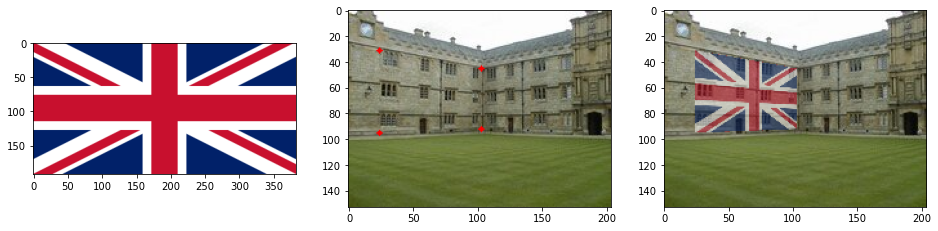

In [2]:
building = cv.imread("assets/warp/building-1.jpg", cv.IMREAD_ANYCOLOR)
flag = cv.imread("assets/warp/flag-uk.png", cv.IMREAD_ANYCOLOR)

source_points = np.array([
    [0,0],
    [flag.shape[1], 0],
    [0, flag.shape[0]],
    [flag.shape[1], flag.shape[0]],
]).astype(np.float32)
destination_points = np.array([
    [24, 31],
    [103, 45],
    [24, 95],
    [103, 92]
]).astype(np.float32)           # By manually inspecting the image
opacity = 0.5 # (should be between 0 and 1)

display_building = building.copy()
for i in range(4):
    cv.circle(display_building, destination_points[i].astype(int), 2, [0,0,255], -1)

homography = cv.getPerspectiveTransform(source_points, destination_points)
warped_img = cv.warpPerspective(flag, homography, building.shape[:2][::-1])
output = building.copy()
boolean_mat = warped_img != 0
output[boolean_mat] = warped_img[boolean_mat]*opacity + building[boolean_mat]*(1-opacity)

fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(cv.cvtColor(flag, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(display_building, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.show()

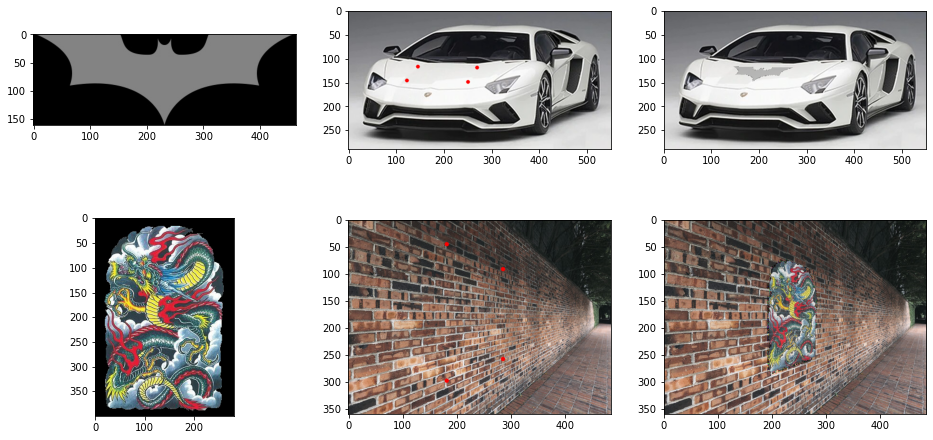

In [11]:
data = []
with open("assets/warp/warp-data.txt") as f:
    data =  f.read().split("\n")

count = int(data[0])
data = list(map(lambda x: x.split(), data[1:]))
fig, ax = plt.subplots(count,3, figsize=(16,4*count))

for i in range(count):
    background = cv.imread("assets/warp/"+data[i][0], cv.IMREAD_ANYCOLOR)
    foreground = cv.imread("assets/warp/"+data[i][1], cv.IMREAD_ANYCOLOR)
    source_points = np.array([
        [0,0],
        [foreground.shape[1], 0],
        [0, foreground.shape[0]],
        [foreground.shape[1], foreground.shape[0]],
    ]).astype(np.float32)
    destination_points = np.array(data[i][2:10]).reshape((4,2)).astype(np.float32)           # By manually inspecting the image
    opacity = float(data[i][10]) # (should be between 0 and 1)

    display_background = background.copy()
    for j in range(4):
        cv.circle(display_background, destination_points[j].astype(int), 4, [0,0,255], -1)

    homography = cv.getPerspectiveTransform(source_points, destination_points)
    warped_img = cv.warpPerspective(foreground, homography, background.shape[:2][::-1])
    output = background.copy()
    boolean_mat = warped_img != 0
    output[boolean_mat] = warped_img[boolean_mat]*opacity + background[boolean_mat]*(1-opacity)

    ax[i][0].imshow(cv.cvtColor(foreground, cv.COLOR_BGR2RGB))
    ax[i][1].imshow(cv.cvtColor(display_background, cv.COLOR_BGR2RGB))
    ax[i][2].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))

plt.show()

# Q3

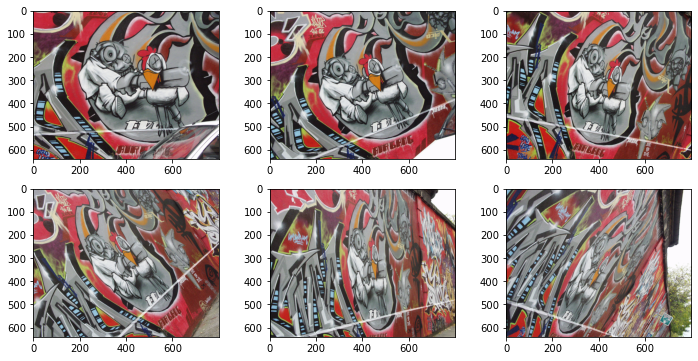

In [17]:
im1 = cv.imread("assets/graf/img1.ppm")
im2 = cv.imread("assets/graf/img2.ppm")
im3 = cv.imread("assets/graf/img3.ppm")
im4 = cv.imread("assets/graf/img4.ppm")
im5 = cv.imread("assets/graf/img5.ppm")
im6 = cv.imread("assets/graf/img6.ppm")

fig, ax = plt.subplots(2,3,figsize=(4*3, 3*2))
ax[0][0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0][1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[0][2].imshow(cv.cvtColor(im3, cv.COLOR_BGR2RGB))
ax[1][0].imshow(cv.cvtColor(im4, cv.COLOR_BGR2RGB))
ax[1][1].imshow(cv.cvtColor(im5, cv.COLOR_BGR2RGB))
ax[1][2].imshow(cv.cvtColor(im6, cv.COLOR_BGR2RGB))

plt.show()

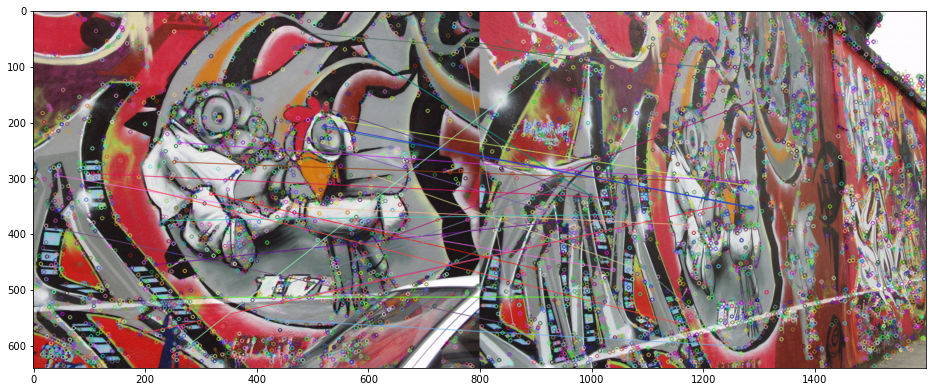

In [82]:
im1 = cv.imread("assets/graf/img1.ppm", cv.IMREAD_ANYCOLOR)
im5 = cv.imread("assets/graf/img5.ppm", cv.IMREAD_ANYCOLOR)

# sift object
sift = cv.SIFT_create()
# matcher
index_params = {"algorithm":1, "trees":5}
search_params = {"checks":100000}
flann = cv.FlannBasedMatcher(index_params, search_params)

kp1, desc1 = sift.detectAndCompute(im1, None)
kp5, desc5 = sift.detectAndCompute(im5, None)
matches = flann.knnMatch(desc1, desc5, k=2)
good_matches = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good_matches.append(m)
good_matches = np.array(sorted(good_matches, key=lambda x: x.distance))

matched_im = cv.drawMatches(im1, kp1, im5, kp5, good_matches, im5)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(cv.cvtColor(matched_im, cv.COLOR_BGR2RGB))

plt.show()


In [52]:
# def getInlierCount(pts1, pts2, homography, dist):
# good_matches.shape
def getRandomHomography(matches):
    sample_indices = np.random.randint(0, len(matches), 4)
    samples = matches[sample_indices]

    queryIdxs = list(map(lambda x: x.queryIdx, samples))
    trainIdxs = list(map(lambda x: x.trainIdx, samples))

    source_points = np.array(list(map(lambda x: x.pt, np.array(kp1)[queryIdxs]))).astype(np.float32)
    destination_points = np.array(list(map(lambda x: x.pt, np.array(kp5)[trainIdxs]))).astype(np.float32)

    homography = cv.getPerspectiveTransform(source_points, destination_points)

    return homography

def getAllPoints(matches):
    queryIdxs = list(map(lambda x: x.queryIdx, matches))
    trainIdxs = list(map(lambda x: x.trainIdx, matches))

    queryPoints = np.array(list(map(lambda x: x.pt, np.array(kp1)[queryIdxs]))).astype(np.float32)
    trainPoints = np.array(list(map(lambda x: x.pt, np.array(kp5)[trainIdxs]))).astype(np.float32)


    return queryPoints, trainPoints

def applyHomography(homography, trainPoints):
    multPoints = np.vstack((trainPoints.T, np.ones(trainPoints.shape[0])))
    transformedPoints = homography @ multPoints
    transformedPoints = transformedPoints[0:2, :].T

    return transformedPoints

def getErrorDist(img, frac=0.1):
    avgLen = np.array(img.shape).sum()/2
    error = avgLen*frac

    return error

def getInlierCount(pts1, pts2, errorDist):
    dif = pts1 - pts2
    square = dif**2
    dist = np.sqrt(square.sum(axis=1))
    inlierCount = sum(dist <= errorDist)

    return inlierCount

22


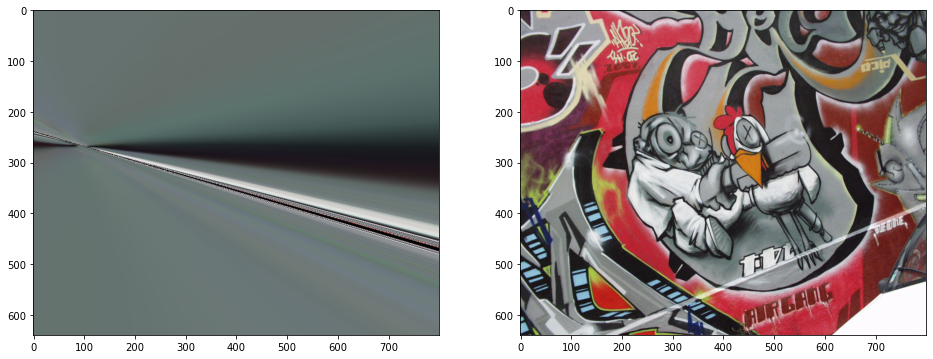

In [74]:

N = good_matches.size
queryPoints, trainPoints = getAllPoints(good_matches)
bestHomography = np.zeros((3,3))
maxInlierCount = 0
np.random.seed(1)
for i in range(N):
    homography = getRandomHomography(good_matches)
    transformedPoints = applyHomography(homography, trainPoints)
    errorDist = getErrorDist(im1, 0.2)
    inlierCount = getInlierCount(queryPoints, transformedPoints, errorDist)
    
    if inlierCount > maxInlierCount:
        maxInlierCount = inlierCount
        bestHomography = homography


print(maxInlierCount)
output = cv.warpPerspective(im1, bestHomography, im1.shape[:2][::-1])

fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))

plt.show()
    
